In [19]:
# Set up working environment for CoLoMoTo
import maboss
import biolqm
import ginsim
import numpy as np

from colomoto_jupyter import tabulate
# for fixpoint table display
from itertools import combinations
# for iterating over sets
import matplotlib.pyplot as plt
# for modifying plots

from scipy.spatial import distance
from scipy.stats import norm
from random import shuffle
from scipy.interpolate import CubicSpline
from scipy.integrate import quad
from scipy.integrate import quad_explain

In [20]:
bnd_file = "model3.6.bnd"
cfg_WT = "model3.6.cfg"
WT = maboss.load(bnd_file, cfg_WT)

In [21]:
# define model parameters
maxT = 400;
slowRate = 0.012; # fit parameter
fastRate = 1;
standardRate = 0.84; # fit parameter
maxT = 400;
theta = 0.3;
sigma = 0.14;
samples = 10000;

In [22]:
#define functions
def getExitTimes(run, N):
    tc = run.get_nodes_probtraj()
    tc2 = tc["ME"].tolist() # get time course as a list 
    tcT = tc.index.tolist()
    dt = tcT[1]-tcT[0]
    diff = (np.asarray(tc2[2:len(tc2)])-np.asarray(tc2[1:(len(tc2)-1)]))/dt# get difference between tc points
    mids = (np.asarray(tcT[2:len(tcT)])+np.asarray(tcT[1:(len(tcT)-1)]))/2
    diff_red = list()
    mids_red = list()
    n = len(tc2)
    k = int(n/N)
    for i in range(0,k):
        diff_red.append(np.mean(diff[N*i:N*i+N]))
        mids_red.append(np.mean(mids[N*i:N*i+N]))
    return(np.array([mids_red, diff_red]))

def exit2Av(mids,diff):
    dt = mids[1]-mids[0]
    Av = sum(mids*diff)*dt
    return(Av)

def spindle_align(dt, sigma, theta):
    exit = 0
    x = np.random.uniform(-np.pi/2,np.pi/2)
    t = 0
    iteration = 0
    if x>np.pi/2 -theta or x<-np.pi/2 +theta:
        exit = 1
    while exit==0:
        if (iteration/1000) - np.floor(iteration/1000) == 0: # save time by calculating 1000 rvs in one go
            rands = norm.rvs(size=1000, scale=sigma*np.sqrt(dt))
            iteration = 0
        t = t + dt
        x = x + rands[iteration]
        if x>np.pi/2 -theta:
            exit = 1
        elif x<-np.pi/2 +theta:
            exit = 1
        iteration = iteration+1
    return t

In [23]:
nodes = list(WT.network.keys()) # this creates an iterable list of nodes

for k in range(0,len(nodes)-1):
    WT = maboss.copy_and_update_parameters(WT, {'$u_'+nodes[k]:standardRate})
    WT = maboss.copy_and_update_parameters(WT, {'$d_'+nodes[k]:standardRate})

WT_allinputs = maboss.copy_and_update_parameters(WT, {'max_time':maxT})
WT_allinputs = maboss.copy_and_update_parameters(WT_allinputs, {'$slow':slowRate})
WT_allinputs = maboss.copy_and_update_parameters(WT_allinputs, {'$fast':fastRate})
WT_allinputs = maboss.copy_and_update_parameters(WT_allinputs, {'sample_count':samples})


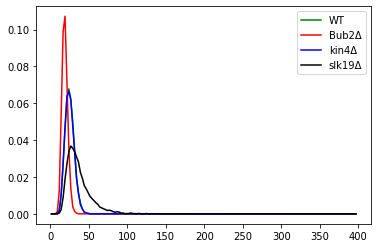

In [24]:
# late anaphase timings
WTLA = WT_allinputs.copy()
WTLA.network.set_istate("SpindleAlign", [0,1]) 
WTLA.network.set_istate("SACA_Nucleus", [1,0]) 
mut_Bub2_OFF_LA = WTLA.copy()
for name in "Bub2lowL_Nucleus Bub2lowL_Cytoplasm Bub2lowL_Bud Bub2lowL_dSPB Bub2lowL_mSPB Bub2highL_Nucleus Bub2highL_Cytoplasm Bub2highL_Bud Bub2highL_dSPB Bub2highL_mSPB".split(' '):
    mut_Bub2_OFF_LA.mutate(name, "OFF")
mut_Kin4_OFF_LA = WTLA.copy()
for name in "Kin4L_Nucleus Kin4L_Cytoplasm Kin4L_Bud Kin4L_dSPB Kin4L_mSPB".split(' '):
         mut_Kin4_OFF_LA.mutate(name, "OFF")
mut_Slk19_OFF_LA = WTLA.copy()
for name in "Slk19L_Nucleus Slk19L_Cytoplasm Slk19L_Bud".split(' '):
         mut_Slk19_OFF_LA.mutate(name, "OFF")
run_WT_LA = WTLA.run()
run_Bub2_OFF_LA = mut_Bub2_OFF_LA.run()
run_Kin4_OFF_LA = mut_Kin4_OFF_LA.run()
run_Slk19_OFF_LA = mut_Slk19_OFF_LA.run()
exits_WT = getExitTimes(run_WT_LA,5)
exits_Bub2 = getExitTimes(run_Bub2_OFF_LA,5)
exits_Kin4 = getExitTimes(run_Kin4_OFF_LA,5)
exits_Slk19 = getExitTimes(run_Slk19_OFF_LA,5)
plt.figure()
plt.plot(exits_WT[0,:], exits_WT[1,:], 'g', label = u'WT')
plt.plot(exits_Bub2[0,:], exits_Bub2[1,:], 'r', label = u'Bub2Δ')
plt.plot(exits_Kin4[0,:], exits_Kin4[1,:],'b', label = u"kin4Δ")
plt.plot(exits_Slk19[0,:], exits_Slk19[1,:],'k', label = u"slk19Δ")
plt.legend()

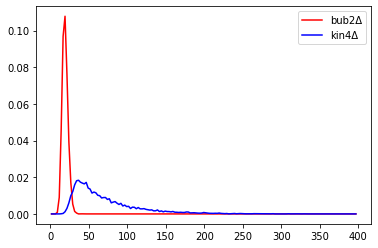

In [25]:
# early anaphase timings
WT_allinputs = maboss.copy_and_update_parameters(WT_allinputs, {'$slow':slowRate})

WTEA = WT_allinputs.copy()
WTEA.network.set_istate("SpindleAlign", [1,0]) 
WTEA.network.set_istate("SACA_Nucleus", [1,0]) 
mut_Bub2_OFF_EA = WTEA.copy()
for name in "Bub2lowL_Nucleus Bub2lowL_Cytoplasm Bub2lowL_Bud Bub2lowL_dSPB Bub2lowL_mSPB Bub2highL_Nucleus Bub2highL_Cytoplasm Bub2highL_Bud Bub2highL_dSPB Bub2highL_mSPB".split(' '):
    mut_Bub2_OFF_EA.mutate(name, "OFF")
mut_Kin4_OFF_EA = WTEA.copy()
for name in "Kin4L_Nucleus Kin4L_Cytoplasm Kin4L_Bud Kin4L_dSPB Kin4L_mSPB".split(' '):
         mut_Kin4_OFF_EA.mutate(name, "OFF")
run_Bub2_OFF_EA = mut_Bub2_OFF_EA.run()
run_Kin4_OFF_EA = mut_Kin4_OFF_EA.run()
exits_Bub2 = getExitTimes(run_Bub2_OFF_EA,5)
exits_Kin4 = getExitTimes(run_Kin4_OFF_EA,5)
plt.figure()
plt.plot(exits_Bub2[0,:], exits_Bub2[1,:], 'r', label = u'bub2Δ')
plt.plot(exits_Kin4[0,:], exits_Kin4[1,:],'b', label = u"kin4Δ")
plt.legend()
kin4av = exit2Av(exits_Kin4[0,:], exits_Kin4[1,:])
bub2av = exit2Av(exits_Bub2[0,:], exits_Bub2[1,:])


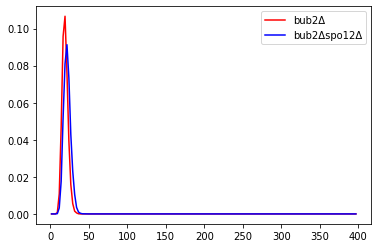

In [199]:
# FEAR delete in early anaphase
run_Bub2_Spo12_OFF_EA = mut_Bub2_Spo12_OFF_EA.run()
exits_Bub2_Spo12 = getExitTimes(run_Bub2_Spo12_OFF_EA,5)
plt.figure()
plt.plot(exits_Bub2[0,:], exits_Bub2[1,:], 'r', label = u'bub2Δ')
plt.plot(exits_Bub2_Spo12[0,:], exits_Bub2_Spo12[1,:],'b', label = u"bub2Δspo12Δ")
plt.legend()

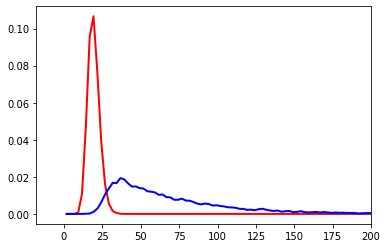

In [72]:
plt.figure()
plt.plot(exits_Bub2[0,:], exits_Bub2[1,:], 'r', label = u'bub2Δ', linewidth = 2)
plt.plot(exits_Kin4[0,:], exits_Kin4[1,:],'b', label = u"kin4Δ", linewidth = 2)
plt.xlim(right=200)
plt.savefig('SPoCStrengths.eps', dpi = 300)

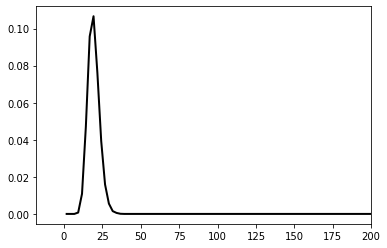

In [75]:
plt.figure()
plt.plot(exits_Bub2[0,:], exits_Bub2[1,:], 'k', label = u'bub2Δ', linewidth = 2)
plt.xlim(right=200)
plt.savefig('bub2Delta.eps', dpi = 300)

In [26]:
# average length of anaphase in kin4 delta
kin4av

70.14652500000001

In [27]:
# average length of anaphase in bub2 delta
bub2av

19.367877500000002

In [7]:
# Spindle alignment simulations
dt = 0.0025
alltimes = list()
for k in range(samples):
    alltimes.append(spindle_align(dt, sigma, theta))


In [24]:
# define pdfs of relevant distributions
def fB(x): # fB - exit time distribution for bub2 delete
    if isinstance(x,np.ndarray):
        y = list()
        for xi in x:
            if (xi<0) or (xi>400):
                yi = 0
            else :
                f = CubicSpline(exits_Bub2[0,:],exits_Bub2[1,:])
                yi = f(xi)
            y.append(yi)
        return(np.array(y))
    else :
        if (x<0) or (x>400):
            y = 0
        else :
            f = CubicSpline(exits_Bub2[0,:],exits_Bub2[1,:])
            y = f(x)
        return(y)
    
def fK(x): # fK - exit time distribution for kin4 delete
    if isinstance(x,np.ndarray):
        y = list()
        for xi in x:
            if (xi<0) or (xi>400):
                yi = 0
            else :
                f = CubicSpline(exits_Kin4[0,:],exits_Kin4[1,:])
                yi = f(xi)
            y.append(yi)
        return(np.array(y))
    else :
        if (x<0) or (x>400):
            y = 0
        else :
            f = CubicSpline(exits_Kin4[0,:],exits_Kin4[1,:])
            y = f(x)
        return(y)

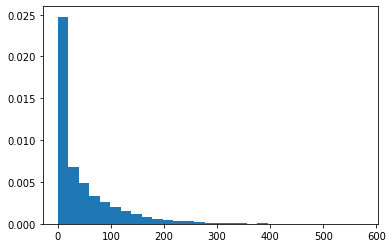

In [11]:
# set parameters
N = 1000 
t = np.linspace(-1000,1000, num = N)
dt = t[1]-t[0]

# define ft - PDF of alignment time distribution
bins = np.linspace(0, max(alltimes), 30)
plt.figure()
hist_times = plt.hist(alltimes,bins = bins,density  = True);
hist_mids = (hist_times[1][1:len(hist_times[1])] + hist_times[1][0:(len(hist_times[1])-1)])/2
def ft(x):
    if isinstance(x,np.ndarray):
        y = list()
        for xi in x:
            if (xi<0) or (xi>max(alltimes)):
                yi = 0
            else :
                f = CubicSpline(hist_mids,hist_times[0])
                yi = f(xi)
            y.append(yi)
        return(np.array(y))
    else :
        if (x<0) or (x>max(alltimes)):
            y = 0
        else :
            f = CubicSpline(hist_mids,hist_times[0])
            y = f(x)
        return(y)
T = ft(t)[::-1]

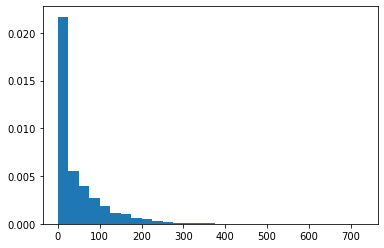

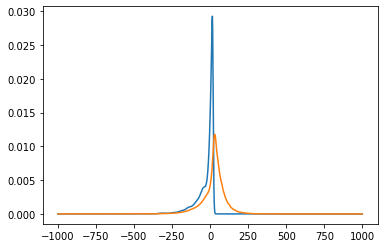

In [100]:

Eb = fB(t)/sum(fB(t)) # normalise to ensure proper pdf
Ek = fK(t)/sum(fK(t))
Bub2_diffs = np.convolve(Eb, T, mode = "same") # convolution to define difference distribution
Kin4_diffs = np.convolve(Ek, T, mode = "same")
plt.figure()
plt.plot(t, Bub2_diffs)
plt.plot(t, Kin4_diffs)
Bub2_SPoC = sum(Bub2_diffs[0:(int(N/2))-2]+Bub2_diffs[1:(int(N/2))-1])*dt/2
Kin4_SPoC = sum(Kin4_diffs[0:(int(N/2))-2]+Kin4_diffs[1:(int(N/2))-1])*dt/2

    

In [101]:
Bub2_SPoC

0.4958545665841157

In [102]:
Kin4_SPoC

0.25720186035665604

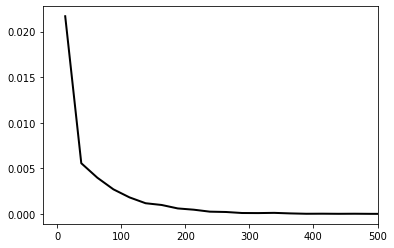

In [106]:
plt.plot(hist_mids, hist_times[0], color = 'k', linewidth = 2)
plt.xlim(right = 500)
plt.savefig('Aligntimes.eps', dpi = 300)

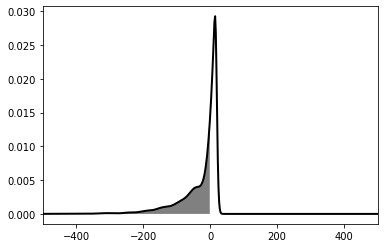

In [107]:
ax = plt.plot(t, Bub2_diffs, color = 'k', linewidth = 2)
plt.fill_between(t, 0,Bub2_diffs, where = t<=0,facecolor='grey', interpolate=True)
plt.xlim([-500, 500])
plt.savefig('differencedistribution.eps', dpi = 300)

In [52]:
def spindle_align_plot(dt, T, sigma, theta): # function to make plot of sample Brownian motions
    x = np.random.uniform(-np.pi/2,np.pi/2)
    xs = list()
    iteration = 0
    N = int(T/dt)
    for j in range(N):
        if (iteration/1000) - np.floor(iteration/1000) == 0: # save time by calculating 1000 rvs in one go
            rands = norm.rvs(size=1000, scale=sigma*np.sqrt(dt))
            iteration = 0
        x = x + rands[iteration]
        xs.append(x)
        iteration = iteration+1
    plt.plot(np.arange(0,T,dt), xs, linewidth = 0.5)


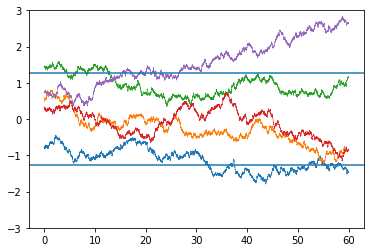

In [70]:
for j in range(5):
    spindle_align_plot(0.0025, 60, sigma, theta)
plt.axhline(y=np.pi/2 -theta)
plt.axhline(y=-np.pi/2 +theta)
plt.ylim([-3,3])
plt.savefig('BrownianMotion.eps', dpi = 300)

In [8]:
# define all mutants needed for analysis
WTEA = WT_allinputs.copy()
WTEA.network.set_istate("SpindleAlign", [1,0]) 
WTEA.network.set_istate("SACA_Nucleus", [1,0]) 
mut_Bub2_OFF_EA = WTEA.copy()
for name in "Bub2lowL_Nucleus Bub2lowL_Cytoplasm Bub2lowL_Bud Bub2lowL_dSPB Bub2lowL_mSPB Bub2highL_Nucleus Bub2highL_Cytoplasm Bub2highL_Bud Bub2highL_dSPB Bub2highL_mSPB".split(' '):
    mut_Bub2_OFF_EA.mutate(name, "OFF")
mut_Kin4_OFF_EA = WTEA.copy()
for name in "Kin4L_Nucleus Kin4L_Cytoplasm Kin4L_Bud Kin4L_dSPB Kin4L_mSPB".split(' '):
         mut_Kin4_OFF_EA.mutate(name, "OFF")
mut_Spo12_OFF_EA = WTEA.copy()
for name in "Spo12L_Nucleus Spo12L_Cytoplasm Spo12L_Bud".split(' '):
         mut_Spo12_OFF_EA.mutate(name, "OFF")
mut_Bub2_Spo12_OFF_EA = mut_Bub2_OFF_EA.copy()
for name in "Spo12L_Nucleus Spo12L_Cytoplasm Spo12L_Bud".split(' '):
         mut_Bub2_Spo12_OFF_EA.mutate(name, "OFF")
mut_LTE1_8N_EA = WTEA.copy()
for name in "Lte1L_Cytoplasm".split(' '):
         mut_LTE1_8N_EA.mutate(name, "ON")
mut_LTE1_8N_Spo12_OFF_EA = mut_Spo12_OFF_EA.copy()
for name in "Lte1L_Cytoplasm".split(' '):
         mut_LTE1_8N_Spo12_OFF_EA.mutate(name, "ON")
mut_Spo12_Kin4_OFF_EA = mut_Kin4_OFF_EA.copy()
for name in "Spo12L_Nucleus Spo12L_Cytoplasm Spo12L_Bud".split(' '):
         mut_Spo12_Kin4_OFF_EA.mutate(name, "OFF")        
mut_LTE1_8N_Kin4_OFF_EA = mut_Kin4_OFF_EA.copy()
for name in "Lte1L_Cytoplasm".split(' '):
         mut_LTE1_8N_Kin4_OFF_EA.mutate(name, "ON")        
mut_LTE1_8N_Spo12_Kin4_OFF_EA = mut_Spo12_Kin4_OFF_EA.copy()
for name in "Lte1L_Cytoplasm".split(' '):
         mut_LTE1_8N_Spo12_Kin4_OFF_EA.mutate(name, "ON")         
        
        

In [9]:
def SPoCStrength(model, ft, tmax, N, plot = False): # function to take mutant model and ft, then calculate proportion of multinucleate cells
    run = model.run()
    traj = run.get_nodes_probtraj()

    if np.shape(traj)[1]==0: # check if no column (ie ME never occurs)
        return(0)
    elif traj["ME"].tolist()[np.shape(traj["ME"].tolist())[0]-1] < 0.95: # this fixes issue where ME node is transiently activated
        return(0)
    else:
        exits = getExitTimes(run,5)
        def fE(x): # define PDF
            if isinstance(x,np.ndarray):
                y = list()
                for xi in x:
                    if (xi<0) or (xi>400):
                        yi = 0
                    else :
                        f = CubicSpline(exits[0,:],exits[1,:])
                        yi = f(xi)
                    y.append(yi)
                return(np.array(y))
            else :
                if (x<0) or (x>400):
                    y = 0
                else :
                    f = CubicSpline(exits[0,:],exits[1,:])
                    y = f(x)
                return(y)
        t = np.linspace(-tmax,tmax,N)
        dt = t[1]-t[0]
        T = ft(t)[::-1]
        E = fE(t)/sum(fE(t)) # normalise to ensure proper pdf
        Diffs = np.convolve(E, T, mode = "same")
        M = max(np.where(t<0)[0]) # find first value below 0 
        SPoC = sum(Diffs[0:M-1]+Diffs[1:M])*dt/2 # numerical integral to approximate proportion of multinucleate cells
        if plot:
            plt.plot(t, Diffs)

        return SPoC
    
    
    
    

0.4959899427715682

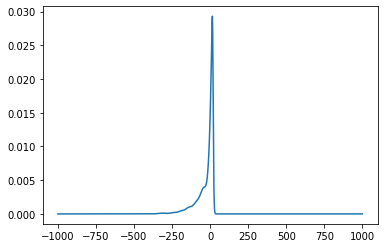

In [122]:
SPoCStrength(mut_Bub2_OFF_EA, ft, 1000, 1000, plot = True)

In [15]:
models = list(["WTEA", "mut_Spo12_OFF_EA","mut_Bub2_OFF_EA", "mut_Bub2_Spo12_OFF_EA", "mut_Kin4_OFF_EA", "mut_Spo12_Kin4_OFF_EA", "mut_LTE1_8N_EA", "mut_LTE1_8N_Spo12_OFF_EA", "mut_LTE1_8N_Kin4_OFF_EA", "mut_LTE1_8N_Spo12_Kin4_OFF_EA"])
SPoCStrengths = list()
for m in models:
    SPoCStrengths.append(SPoCStrength(eval(m), ft, 1000, 1000, plot = False))




In [16]:
SPoCStrengths

[0,
 0,
 0.48899388244705483,
 0.4641899398735398,
 0.26317019578563206,
 0,
 0.45750414591564165,
 0.4142650476970949,
 0.45931127807369043,
 0.4161064969949974]

In [17]:
models

['WTEA',
 'mut_Spo12_OFF_EA',
 'mut_Bub2_OFF_EA',
 'mut_Bub2_Spo12_OFF_EA',
 'mut_Kin4_OFF_EA',
 'mut_Spo12_Kin4_OFF_EA',
 'mut_LTE1_8N_EA',
 'mut_LTE1_8N_Spo12_OFF_EA',
 'mut_LTE1_8N_Kin4_OFF_EA',
 'mut_LTE1_8N_Spo12_Kin4_OFF_EA']

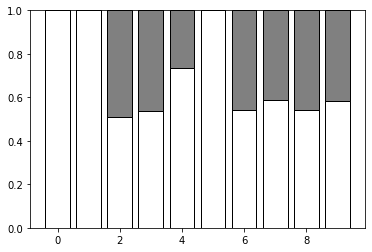

In [18]:
# plot bar chart
SPoCInvert1 = 1-np.array(SPoCStrengths)
plt.bar(np.arange(10),SPoCInvert1, color = "white", edgecolor = "black")
plt.bar(np.arange(10),SPoCStrengths, bottom = SPoCInvert1, color = "grey", edgecolor = "black")
plt.savefig('partialPhenos1.eps', dpi = 300)

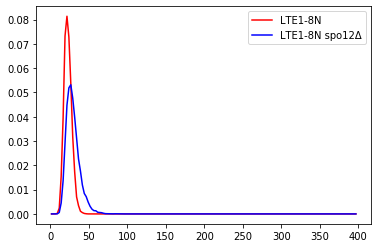

In [200]:
# see time difference in LTE1-8N spo12 cells
run_LTE1_8N_Spo12_OFF_EA = mut_LTE1_8N_Spo12_OFF_EA.run()
run_LTE1_8N_EA = mut_LTE1_8N_EA.run()
exits_LTE1_8N_Spo12_OFF = getExitTimes(run_LTE1_8N_Spo12_OFF_EA,5)
exits_LTE1_8N = getExitTimes(run_LTE1_8N_EA,5)
plt.figure()
plt.plot(exits_LTE1_8N[0,:], exits_LTE1_8N[1,:], 'r', label = u'LTE1-8N')
plt.plot(exits_LTE1_8N_Spo12_OFF[0,:], exits_LTE1_8N_Spo12_OFF[1,:],'b', label = u"LTE1-8N spo12Δ")
plt.legend()